In [1]:
#%%
import sys, os, json
from pathlib import Path
home_path = "/Users/nd21aad/Phd/Projects/enose-analysis-crick"  # Define project root directory
os.chdir(home_path)         # Change working directory to project root directory
sys.path.append(home_path)  # Add project root directory to python path
home_path = Path(home_path)

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option("display.max_columns", None)
new_rc_params = {"text.usetex": False, "svg.fonttype": "none"}
mpl.rcParams.update(new_rc_params)

import src.pulse_classification.analysis as analysis
import src.utils.constants as constants
import src.pulse_classification.helpers as utils
import src.visualizations.pulse_classification as visualizations

np.random.seed(42)

In [2]:
# Define data dirs
parent_dir = Path('/Volumes/SSDExtreme/Work/Data/Crick')    # Change this to the directory where you store the data
data_dir_enose = parent_dir.joinpath('Dataset-FastMachineOlfaction/Enose')
data_dir_pid = parent_dir.joinpath('Dataset-FastMachineOlfaction/PID/Full')
assert data_dir_enose.exists(), f'{data_dir_enose} does not exist'
assert data_dir_pid.exists(), f'{data_dir_pid} does not exist'

# Define results dir
result_dir_parent = home_path.joinpath("results/pulse_classification")
result_dir_parent.mkdir(exist_ok=True, parents=True)
result_dir = result_dir_parent.joinpath('dynamic')
result_dir.mkdir(exist_ok=True, parents=True)

In [3]:
# Load data index
condition = 'Lcycle25msRcycle25ms'
index_file = data_dir_enose.joinpath("index.csv")
index_df = pd.read_csv(index_file)
index_df = index_df.replace('b1', 'blank')
index_df = index_df.replace('b2', 'blank')
index_df = index_df[index_df['condition']==condition]
experiment_name = "test"#data_file.split(sep="/")[-1]

# Create results directories
results_dir_single_pulses = result_dir.joinpath("single_pulses")
results_dir_acorr = result_dir.joinpath("acorr")
result_dir_plumes = result_dir.joinpath("plumes")
result_dir_plumes_mix = result_dir_plumes.joinpath("mix")
result_dir_plumes_50cm = result_dir_plumes.joinpath("50cm")
for dir in [results_dir_single_pulses, results_dir_acorr, result_dir_plumes_mix, result_dir_plumes_50cm]:#, results_dir_concentrations, results_dir_pca, results_dir_tsne, results_dir_pulse_classification, results_dir_acorr_classification, result_dir_plumes_mix, result_dir_plumes_50cm]:
    dir.mkdir(exist_ok=True, parents=True)

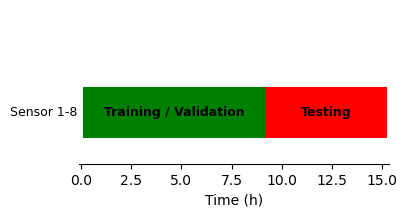

In [4]:
# Get train&val + test data: 1s pulses

# Split train and test
f_test = 0.4
index_df_trainval, index_df_test = utils.split_traintest_time(index_df, f_test=f_test, stratified=False, time_split=True)
# Convert time to hours
index_df_trainval['t_stimulus'] = (pd.to_timedelta(index_df_trainval['t_stimulus'])).dt.total_seconds()/60./60.
index_df_test['t_stimulus'] = pd.to_timedelta(index_df_test['t_stimulus']).dt.total_seconds()/60./60.

# Plot train/val and test splits
plot_traintest = True
if plot_traintest:
    visualizations.plot_traintest_split_dynamic(index_df_trainval, index_df_test, results_dir_single_pulses, show=True)

In [5]:
# Index: 1s pulses
index_df_pulses_1s_c12345_trainval = index_df_trainval.query(f"kind == 'pulse' & condition == '{condition}' & shape == '1.0s'")
index_df_pulses_1s_c12345_test = index_df_test.query(f"kind == 'pulse' & condition == '{condition}' & shape == '1.0s'")

# Index: Shorter pulses
index_df_pulses_shorter_c5_trainval = index_df_trainval.query(f"kind == 'pulse' & condition == '{condition}' & shape != '1.0s' & concentration == 100 & n_saturated == 0")
index_df_pulses_shorter_c5_test = index_df_test.query(f"kind == 'pulse' & condition == '{condition}' & shape != '1.0s' & concentration == 100 & n_saturated == 0")
shortpulses = ['0.5s', '0.2s', '0.1s', '0.05s', '0.02s', '0.01s']
selected_shortpulses_dict_trainval = {sp: index_df_pulses_shorter_c5_trainval.query(f"shape == '{sp}'") for sp in shortpulses}
selected_shortpulses_dict_test = {sp: index_df_pulses_shorter_c5_test.query(f"shape == '{sp}'") for sp in shortpulses}

# Index: Acorr pulses
frequs = ["1Hz", "2Hz", "5Hz", "10Hz", "20Hz", "40Hz", "60Hz"]
mode = 'acorr'
index_df_acorr_trainval = index_df_trainval.query(f"kind == '{mode}' & condition == '{condition}'")
index_df_acorr_test = index_df_test.query(f"kind == '{mode}' & condition == '{condition}'")
selected_acorr_dict_trainval = {w: index_df_acorr_trainval.query(f"shape == '{w}' & n_saturated == 0") for w in frequs}
selected_acorr_dict_test = {w: index_df_acorr_test.query(f"shape == '{w}' & n_saturated == 0") for w in frequs}

# Index: Plumes
index_df_plumes_trainval = index_df_trainval.query(f"kind == 'plume' & condition == '{condition}'")
index_df_plumes_test = index_df_test.query(f"kind == 'plume' & condition == '{condition}'")
selected_plumes_dict_trainval = {w: index_df_plumes_trainval.query(f"shape == '{w}' & n_saturated == 0") for w in frequs}
selected_plumes_dict_test = {w: index_df_plumes_test.query(f"shape == '{w}' & n_saturated == 0") for w in frequs}

# %%
# Set params
params = {
    "gases": ["IA", "Eu", "EB", "2H", "blank"],
    "period": constants.period,
    "ncycles": constants.n_all_cycles,
    "cycles_gas": constants.cycles_gas,
    "cycles_blank": constants.cycles_blank,
    "midpoint": constants.midpoint,
    "endpoints": constants.endpoints,
    "delay": constants.delay,
    "on_buffer": 0,
    "off_buffer": 0,
    "ms_start": -2000,
    "ms_on": 0,
    "ms_off": 1000,
    "ms_end": 4000,
    "classifier": 'SVC_rbf'
}

In [6]:
# Initialise analysis
analysis_enose = analysis.Analysis(data_dir_enose, params=params)
feature = 'cycle_signature'
sensors = [1,2,3,4,5,6,7,8]
sensor_str = analysis_enose.sensors_list2str(sensors)
kfold_indices_train, kfold_indices_val = utils.get_kfold_indices(selected=index_df_pulses_1s_c12345_trainval)

In [7]:
# Get trial data
trial_data_trainval = analysis_enose.get_trial_data(index_df_pulses_1s_c12345_trainval, sensors=sensors)

# Save data for data labelling plots
X, y, _, phases, phases_rejected = analysis_enose.get_X_y_ph(trial_data_all=trial_data_trainval, feature=feature, params=params)
y, phases, phases_rejected = np.array(utils.flatten_list(y)), np.array(utils.flatten_list(phases)), np.array(utils.flatten_list(phases_rejected))
np.save(results_dir_single_pulses.joinpath(f'y.npy'), y)
np.save(results_dir_single_pulses.joinpath(f'phases.npy'), phases)
np.save(results_dir_single_pulses.joinpath(f'phases_rejected.npy'), phases_rejected)
json.dump(params, open(results_dir_single_pulses.joinpath(f'params.json'), 'w'))

In [8]:
# Train on 1s pulses, of all concentrations
all_models = analysis.train_dynamic(kfold_indices_train, trial_data_trainval, analysis_enose, feature, params)

  0%|          | 0/5 [00:00<?, ?it/s]

[Pipeline] .... (step 1 of 2) Processing standardscaler, total=   0.0s


 20%|██        | 1/5 [00:02<00:10,  2.71s/it]

[Pipeline] ............... (step 2 of 2) Processing svc, total=   2.4s
[Pipeline] .... (step 1 of 2) Processing standardscaler, total=   0.0s


 40%|████      | 2/5 [00:05<00:07,  2.65s/it]

[Pipeline] ............... (step 2 of 2) Processing svc, total=   2.4s
[Pipeline] .... (step 1 of 2) Processing standardscaler, total=   0.0s


 60%|██████    | 3/5 [00:07<00:05,  2.61s/it]

[Pipeline] ............... (step 2 of 2) Processing svc, total=   2.3s
[Pipeline] .... (step 1 of 2) Processing standardscaler, total=   0.0s


 80%|████████  | 4/5 [00:10<00:02,  2.61s/it]

[Pipeline] ............... (step 2 of 2) Processing svc, total=   2.3s
[Pipeline] .... (step 1 of 2) Processing standardscaler, total=   0.0s


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]

[Pipeline] ............... (step 2 of 2) Processing svc, total=   2.4s


In [9]:
## Validate on 1s pulses, of all concentrations
widths_val, all_f1_val, all_acc_val, all_detection_val, all_phases_onset_val, all_phases_offset_val = analysis.validate_dynamic(kfold_indices_val, all_models, analysis_enose, trial_data_trainval, selected_shortpulses_dict_trainval, sensors, feature, params, results_dir_single_pulses)

# Save results
np.save(results_dir_single_pulses.joinpath(f'val_widths.npy'), widths_val)
np.save(results_dir_single_pulses.joinpath(f'val_all_f1.npy'), all_f1_val)
np.save(results_dir_single_pulses.joinpath(f'val_all_acc.npy'), all_acc_val)
np.save(results_dir_single_pulses.joinpath(f'val_all_detection.npy'), all_detection_val)
np.save(results_dir_single_pulses.joinpath(f'val_all_phases_onset.npy'), all_phases_onset_val)
np.save(results_dir_single_pulses.joinpath(f'val_all_phases_offset.npy'), all_phases_offset_val)


/opt/homebrew/anaconda3/envs/enose-analysis/lib/python3.10/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [10]:
## Test on 1s pulses, of all concentrations
trial_data_test = analysis_enose.get_trial_data(index_df_pulses_1s_c12345_test, sensors=sensors)
widths_test, all_f1_test, all_acc_test, all_detection_test, all_phases_onset_test, all_phases_offset_test = analysis.test_dynamic(kfold_indices_val, all_models, analysis_enose, trial_data_test, selected_shortpulses_dict_test, sensors, feature, params, results_dir_single_pulses)

# Save results
np.save(results_dir_single_pulses.joinpath(f'test_widths.npy'), widths_test)
np.save(results_dir_single_pulses.joinpath(f'test_all_f1.npy'), all_f1_test)
np.save(results_dir_single_pulses.joinpath(f'test_all_acc.npy'), all_acc_test)
np.save(results_dir_single_pulses.joinpath(f'test_all_detection.npy'), all_detection_test)
np.save(results_dir_single_pulses.joinpath(f'test_all_phases_onset.npy'), all_phases_onset_test)
np.save(results_dir_single_pulses.joinpath(f'test_all_phases_offset.npy'), all_phases_offset_test)

/opt/homebrew/anaconda3/envs/enose-analysis/lib/python3.10/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [11]:
# Testing on anti-correlated pulse trains
freqs, all_acc_gas1, all_acc_gas2, all_detection = analysis.test_dynamic_acorr(selected_acorr_dict_test, analysis_enose, kfold_indices_val, all_models, sensors, feature, params, results_dir_acorr)

In [12]:
y = np.load(results_dir_single_pulses.joinpath(f'y.npy'))
phases = np.load(results_dir_single_pulses.joinpath(f'phases.npy'))
phases_rejected = np.load(results_dir_single_pulses.joinpath(f'phases_rejected.npy'))
params = json.load(open(results_dir_single_pulses.joinpath(f'params.json'), 'r'))

width_ms = 100
y_val_all = np.load(results_dir_single_pulses.joinpath(f'y_val_all_{width_ms}.npy'), allow_pickle=True)
y_pred_val_all = np.load(results_dir_single_pulses.joinpath(f'y_pred_val_all_{width_ms}.npy'), allow_pickle=True)
phases_val_all = np.load(results_dir_single_pulses.joinpath(f'phases_val_all_{width_ms}.npy'), allow_pickle=True)

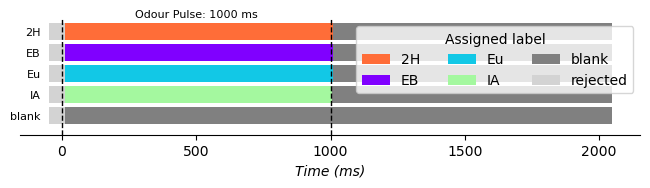

In [13]:
# Validation data
# Plot labels over time
visualizations.plot_labels(y, phases, phases_rejected, params, results_dir_single_pulses)

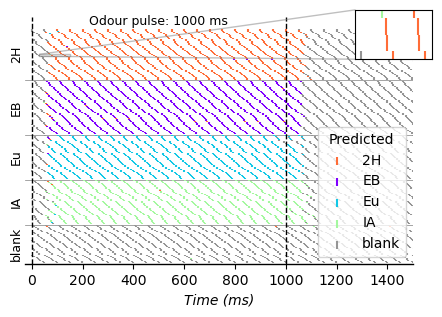

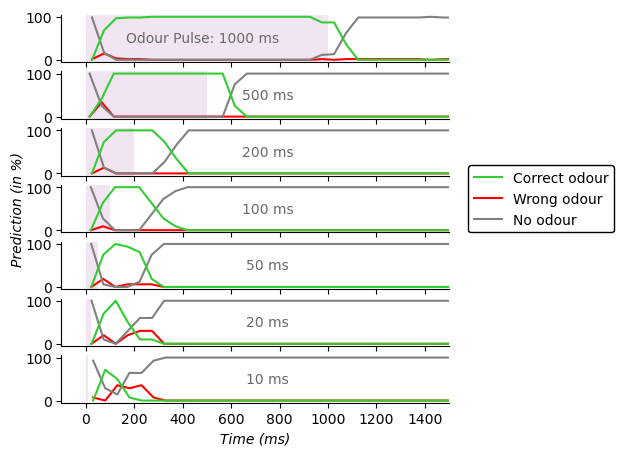

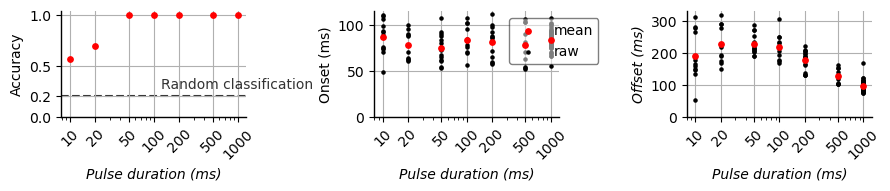

In [14]:
# Validation data
# Plot classifier performances for different pulse durations, over time
widths = np.load(results_dir_single_pulses.joinpath(f'val_widths.npy'))
all_f1 = np.load(results_dir_single_pulses.joinpath(f'val_all_f1.npy'))
all_acc = np.load(results_dir_single_pulses.joinpath(f'val_all_acc.npy'))
all_detection = np.load(results_dir_single_pulses.joinpath(f'val_all_detection.npy'))
all_phases_onset = np.load(results_dir_single_pulses.joinpath(f'val_all_phases_onset.npy'), allow_pickle=True)
all_phases_offset = np.load(results_dir_single_pulses.joinpath(f'val_all_phases_offset.npy'), allow_pickle=True)

y_val_dict, y_pred_val_dict, phases_val_dict = {}, {}, {}
for width_ms in widths:
    y_val_all = np.load(results_dir_single_pulses.joinpath(f'y_val_all_{width_ms}.npy'))
    y_pred_val = np.load(results_dir_single_pulses.joinpath(f'y_pred_val_all_{width_ms}.npy'), allow_pickle=True)
    phases_val_all = np.load(results_dir_single_pulses.joinpath(f'phases_val_all_{width_ms}.npy'))

    if width_ms == 1000:
        splits = 5
    else:
        splits = 1

    y_val_dict[width_ms], y_pred_val_dict[width_ms], phases_val_dict[width_ms] = y_val_all, y_pred_val, phases_val_all

width_ms=1000
visualizations.eventplot_classification_singlepulse(y_val_dict[width_ms], y_pred_val_dict[width_ms], phases_val_dict[width_ms], params, splits=5, width=width_ms, output_dir=results_dir_single_pulses, title=width_ms)
visualizations.summaryplot_classification_singlepulse_comparison(widths, y_val_dict, y_pred_val_dict, phases_val_dict, params, results_dir_single_pulses)
visualizations.scatterplot_statistics_singlepulse(widths, all_acc, all_phases_onset, all_phases_offset, results_dir_single_pulses)

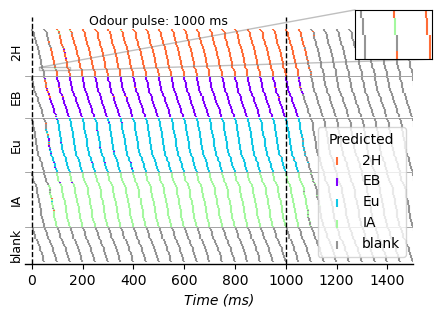

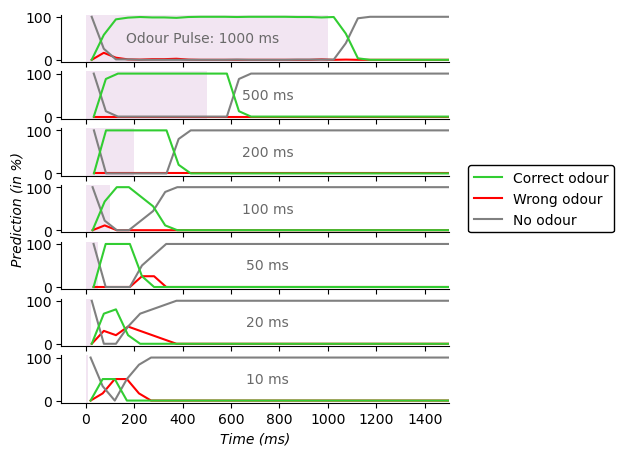

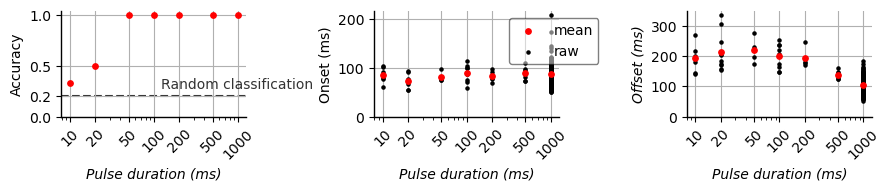

In [15]:
# Test data
# Plot classifier performances for different pulse durations, over time
widths = np.load(results_dir_single_pulses.joinpath(f'test_widths.npy'))
all_f1 = np.load(results_dir_single_pulses.joinpath(f'test_all_f1.npy'))
all_acc = np.load(results_dir_single_pulses.joinpath(f'test_all_acc.npy'))
all_detection = np.load(results_dir_single_pulses.joinpath(f'test_all_detection.npy'))
all_phases_onset = np.load(results_dir_single_pulses.joinpath(f'test_all_phases_onset.npy'), allow_pickle=True)
all_phases_offset = np.load(results_dir_single_pulses.joinpath(f'test_all_phases_offset.npy'), allow_pickle=True)

y_test_dict, y_pred_test_dict, phases_test_dict = {}, {}, {}
for width_ms in widths:
    y_test_all = np.load(results_dir_single_pulses.joinpath(f'y_test_all_{width_ms}.npy'))
    y_pred_test = np.load(results_dir_single_pulses.joinpath(f'y_pred_test_all_{width_ms}.npy'), allow_pickle=True)
    phases_test_all = np.load(results_dir_single_pulses.joinpath(f'phases_test_all_{width_ms}.npy'))

    if width_ms == 1000:
        splits = 5
    else:
        splits = 1
    y_test_dict[width_ms], y_pred_test_dict[width_ms], phases_test_dict[width_ms] = y_test_all, y_pred_test, phases_test_all

width_ms = 1000
visualizations.eventplot_classification_singlepulse(y_test_dict[width_ms], y_pred_test_dict[width_ms], phases_test_dict[width_ms], params, splits=1, width=width_ms, output_dir=results_dir_single_pulses, title=width_ms)
visualizations.summaryplot_classification_singlepulse_comparison(widths, y_test_dict, y_pred_test_dict, phases_test_dict, params, results_dir_single_pulses)
visualizations.scatterplot_statistics_singlepulse(widths, all_acc, all_phases_onset, all_phases_offset, results_dir_single_pulses)
plt.show()

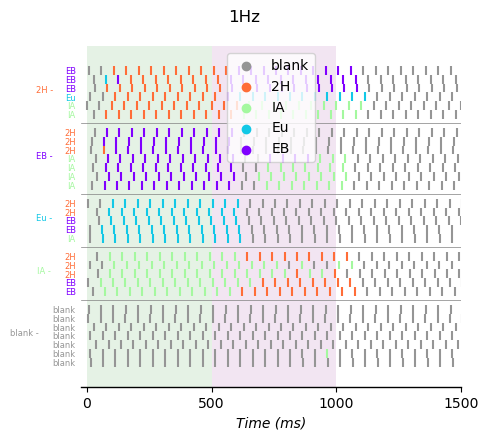

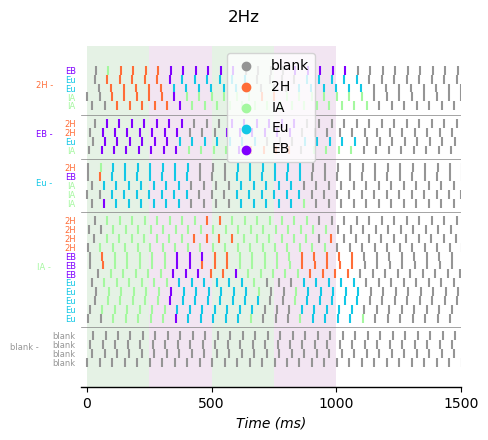

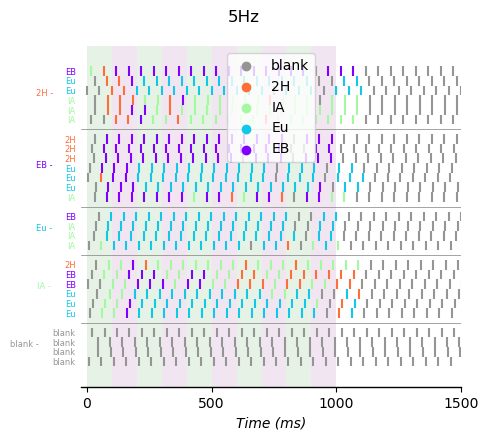

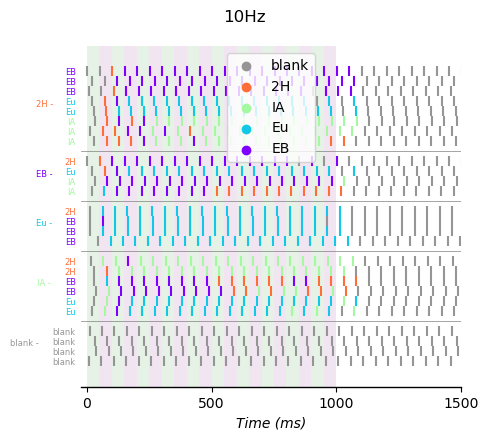

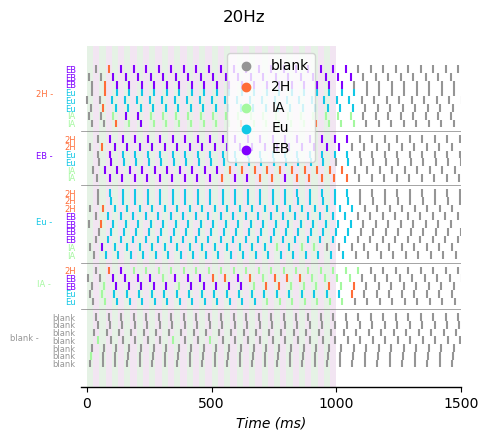

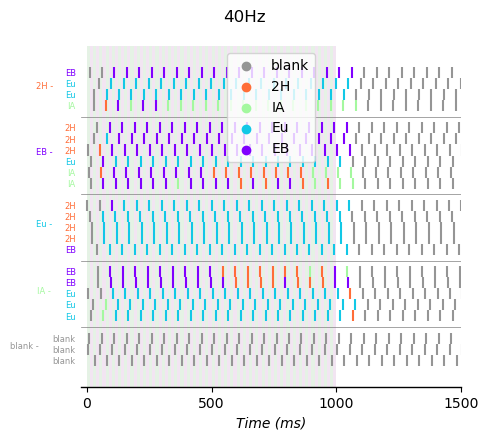

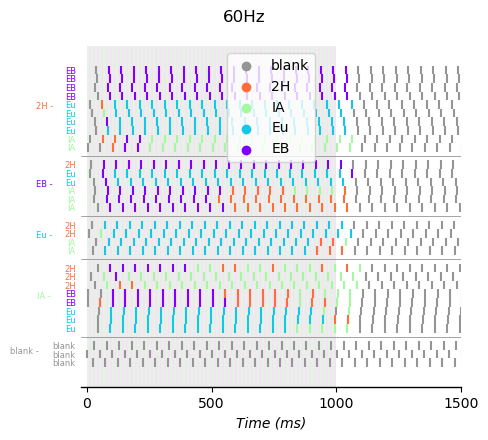

In [16]:
# Test data
# Plot classifier performances for acorr patterns, over time
for freq, mixture_acorr in selected_acorr_dict_test.items():
    y1_test_all = np.load(results_dir_acorr.joinpath(f'y1_test_all_{freq}.npy'), allow_pickle=True)
    y2_test_all = np.load(results_dir_acorr.joinpath(f'y2_test_all_{freq}.npy'), allow_pickle=True)
    y_pred_test_winner = np.load(results_dir_acorr.joinpath(f'y_pred_test_all_{freq}.npy'), allow_pickle=True)
    phases_test_all = np.load(results_dir_acorr.joinpath(f'phases_test_all_{freq}.npy'), allow_pickle=True)
    visualizations.eventplot_classification_twopulses(y1_test_all, y2_test_all, y_pred_test_winner, phases_test_all, period=50, splits=1, title=f"{freq}", freq=int(freq[:-2]), results_dir=results_dir_acorr)
